# 1. 데이터 불러오기

## 1.1 Module

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import math, warnings
%matplotlib inline
warnings.filterwarnings('ignore')

## 1.2 Read csv

In [ ]:
# data 라는 딕셔너리 변수에 각 csv 파일들을 불러온다.
data = {
    'tra':
    pd.read_csv('/gdrive/MyDrive/Colab Notebooks/kaggle/first/data/air_visit_data.csv'),
    'air_store_info':
    pd.read_csv('/gdrive/MyDrive/Colab Notebooks/kaggle/first/data/air_store_info.csv'),
    'hpg_store_info':
    pd.read_csv('/gdrive/MyDrive/Colab Notebooks/kaggle/first/data/hpg_store_info.csv'),
    'air_reserve':
    pd.read_csv('/gdrive/MyDrive/Colab Notebooks/kaggle/first/data/air_reserve.csv'),
    'hpg_reserve':
    pd.read_csv('/gdrive/MyDrive/Colab Notebooks/kaggle/first/data/hpg_reserve.csv'),
    'store_id_relation':
    pd.read_csv('/gdrive/MyDrive/Colab Notebooks/kaggle/first/data/store_id_relation.csv'),
    'tes':
    pd.read_csv('/gdrive/MyDrive/Colab Notebooks/kaggle/first/data/sample_submission.csv'),
    'hol':
    pd.read_csv('/gdrive/MyDrive/Colab Notebooks/kaggle/first/data/date_info.csv').rename(columns={
        'calendar_date': 'visit_date'
    })
}

# 2. 전처리

## 2.1 'hpg_reserve', 'store_id_relation', 'air_reserve' 전처리

- hpg_store_id 를 기준으로 'hpg_reserve'과 'store_id_relation'를 병합한다.
  - merge()함수는 두 데이터프레임을 각 데이터에 존재하는 고유값(key)을 기준으로 병합할때 사용한다.

- 'air_reserve'
  - air_store_id, 예약 및 방문 날짜 시간이 있다.
- 'hpg_reserve'
  - 병합된 'hpg_reserve'에는 hpg_store_id, 예약 및 방문 날싸 시간 + air_store_id 가 있다.
- df[column name].dt.date
  - YYYY-MM-DD(문자) 의 형식으로 바꿔준다.
  - date.date(year, month, day) 의 형태로 년/월/일 정보를 가지는 달력의 날짜(calendar date) 데이터 객체를 생성할 수 있으며, 날짜 객체로 부터 year, month, day attribute로 년(year), 월(month), 일(day) 데이터를 추출할 수 있습니다. 

- to_datetime()
  - DataFrame 열을 datetime 으로 변환하는 함수
  - datetime 형식 문자열없이 스마트 한 방식으로 datetime 으로 변환 할 수 있다. 문자열 패턴을 자동으로 스마트하게 찾는다.
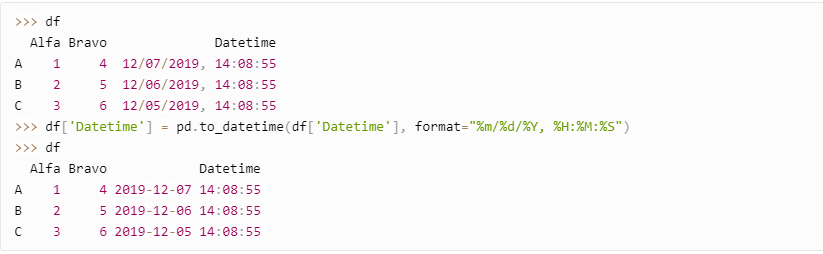

In [ ]:
# 원본
# 각 예약매체(air, hpg)들의 store_id를 확인할 수 있다.
data['store_id_relation'].head() 

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [ ]:
# 원본
# hpg_reserve.csv 에는 hpg에서 예약한 store id와 방문시간, 예약시간, 방문예정자에 대한 데이터가 있다.
# air_reserve.csv 와 틀을 맞춰주기 위해 store_id_relation.csv를 'hpg_store_id'열을 기준으로 병합할 것이다.
data['hpg_reserve'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [ ]:
data['hpg_reserve'] = pd.merge(data['hpg_reserve'], data['store_id_relation'], how='inner', on=['hpg_store_id'])

In [ ]:
# data['hr'] 와 data['id'] 병합 후
data['hpg_reserve'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926


In [ ]:
# 원본
# air_reserve.csv 에는 air에서 예약한 store id와 방문시간, 예약시간, 방문예정자에 대한 데이터가 있다.
data['air_reserve'].head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [ ]:
# air_reserve.csv 와 hpg_reserve.csv 각각의 데이터 프레임의 visit_datetime 열을 년월일로 구분한다.
# visit_datetime 과 reserve_datetime 의 차를 새로운 열 reserve_datetime_diff 에 할당하여
# 방문예약을 한 후 실질적인 방문이 언제쯤인지 전체적인 데이터를 확인한다.

for df in ['air_reserve', 'hpg_reserve']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime']) # 년월일를 분류하기 좋게 나눠준다.
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1) # 각 DataFrame에 visit_datetime 과 reserve_datetime의 차를 새로운 열에 지정해준다.
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[                 # 'air_store_id', 'visit_datetime'를 기준으로 묶은 후 'reserve_datetime_diff', 'reserve_visitors'의 합을 구한다.
            'reserve_datetime_diff', 'reserve_visitors'                       # 그리고 'visit_datetime' 이름을 'visit_date' 로 바꿔준다.
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })
    print(data[df].head())

           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-10-31                      0                 2
1  air_00a91d42b08b08d9  2016-12-05                      4                 9
2  air_00a91d42b08b08d9  2016-12-14                      6                18
3  air_00a91d42b08b08d9  2016-12-17                      6                 2
4  air_00a91d42b08b08d9  2016-12-20                      2                 4
           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-01-14                      3                 2
1  air_00a91d42b08b08d9  2016-01-15                      6                 4
2  air_00a91d42b08b08d9  2016-01-16                      3                 2
3  air_00a91d42b08b08d9  2016-01-22                      3                 2
4  air_00a91d42b08b08d9  2016-01-29                      6                 5


- 위의 결과로 보아 'air_reserve', 'hpg_reserve' 의 열이 같게 정렬된 것을 볼 수 있다.

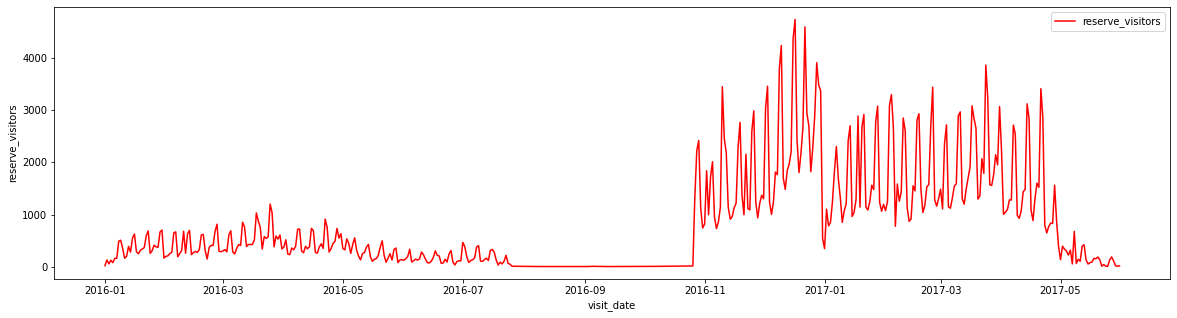

In [ ]:
# 그래프(y축?)
# air_store 방문일 기준으로 예약 방문자
# air_reserve.csv 에는 16년7월 ~ 16년11월 사이의 방문객 기록이 없다.
# 마찬가지로 연말이라 많은 방문자가 있을 것이라 추측해본다.

air_reserve_df = data['air_reserve']
air_reserve_df_vd = air_reserve_df.groupby('visit_date').sum()

ax = air_reserve_df_vd['reserve_visitors'].plot(figsize=[20,5],color='r')
plt.ylabel('reserve_visitors')
plt.legend(loc='upper right')

Text(0, 0.5, 'reserve_visitors')

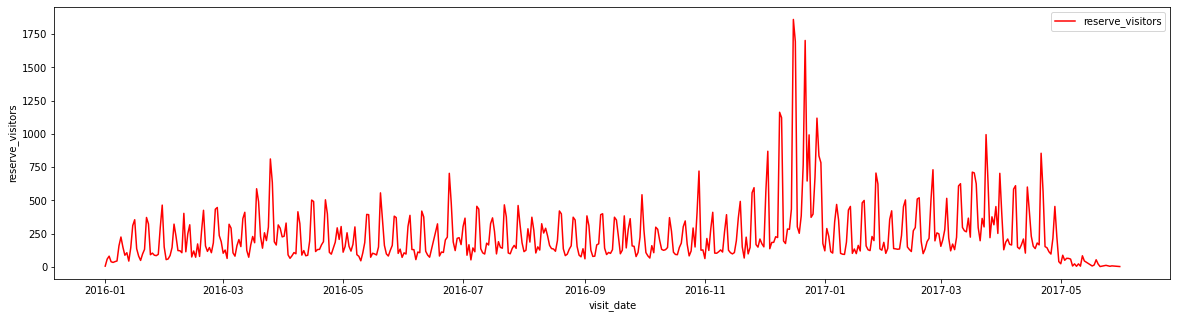

In [ ]:
# 그래프(y축?)
# hpg_store 방문일 기준으로 예약 방문자
# 그래프를 통해 특정요일에 방문을 많이 한다는 정보를 알게 되었다.
# 요일별 방문자수를 air_visit_data.csv에서 확인할 것이다.
# 16년11월 ~ 17년1월 사이에 예약자가 많은 것을 확인할 수 있다.
# 연말이라 많은 방문자가 있을 것이라 추측해본다.

hpg_reserve_df = data['hpg_reserve']
hpg_reserve_df_vd = hpg_reserve_df.groupby('visit_date').sum()

ax = hpg_reserve_df_vd['reserve_visitors'].plot(figsize=[20,5],color='r')
plt.legend(loc='upper right')
plt.ylabel('reserve_visitors')

## 2.2 'air_visit_data' 전처리(1)

In [ ]:
# 원본
# air_visit_data.csv 의 경우 air_store의 방문일자, 방문객수 등 실질적인 데이터가 있다.
# 따라서 air_visit_data.csv를 기준으로 train data를 만들것이다.
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [ ]:
# visit_data 열을 to_datetime 함수를 통해 처리해준다.
# 처리된 visit data 열에서 dt.dayofweek, dt.year, dt.month 를 통해 dow, year, month 열을 새롭게 만든 후 각각 요일을 정수로 반환, 연(4자리숫자), 월(숫자)로 할당 해준다.
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek 
data['tra']['year'] = data['tra']['visit_date'].dt.year 
data['tra']['month'] = data['tra']['visit_date'].dt.month 
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date 

In [ ]:
# 일별
air_visit_data = data['tra'].groupby('visit_date').sum()
air_visit_data.head()

,visitors,dow,year,month
visit_date,,,,
2016-01-01,1033,192,96768,48
2016-01-02,1764,315,127008,63
2016-01-03,2368,486,163296,81
2016-01-04,3326,0,316512,157
2016-01-05,3927,231,465696,231


Text(0, 0.5, 'visitor')

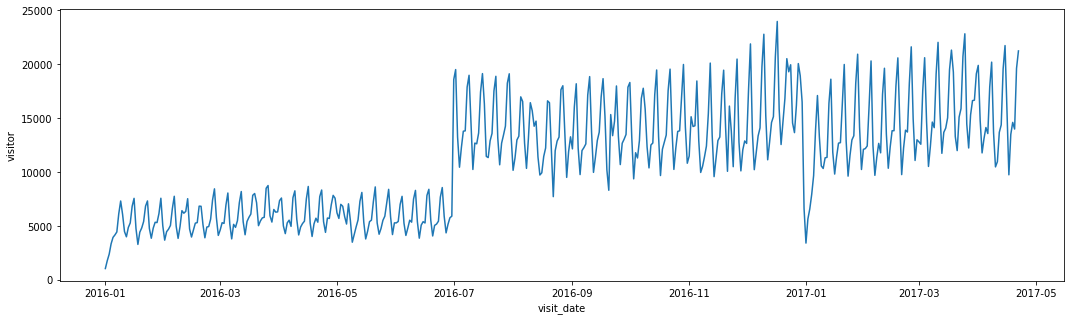

In [ ]:
# 16년 7월 방문자수가 늘었다.
# database에 새로운 가게가 추가되어 7월 이후의 방문자수가 다음과 같이 나타났다고 추측해볼수 있다.
# 연말이 끝난후 연초에는 방문자수가 급감했다.

ax =air_visit_data['visitors'].plot(figsize=[18,5])
plt.ylabel('visitor')

In [ ]:
# 달별
# 일별과 비슷한 양상을 띈다.
air_visit_data_month = data['tra'].groupby(['year', 'month']).sum()
air_visit_data_month

visitors    dow
year month                 
2016 1        152924  22845
     2        159934  22153
     3        189292  24172
     4        182272  25114
     5        179618  24004
     6        175822  24459
     7        455702  68801
     8        408300  58388
     9        414673  63845
     10       436183  66316
     11       413283  60606
     12       497617  65613
2017 1        386848  59279
     2        401462  59398
     3        495487  67383
     4        338236  48909

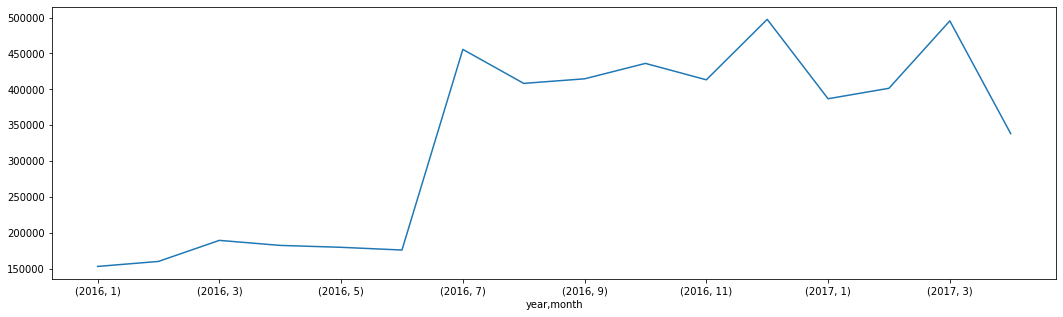

In [ ]:
ax = air_visit_data_month['visitors'].plot(figsize=[18,5])

In [ ]:
# 요일별 방문자
air_visit_data_day = data['tra'].groupby('dow').sum()
air_visit_data_day

,visitors,year,month
dow,,,
0,544202,63880621,196640
1,636462,72617169,223532
2,707880,74222211,229149
3,718987,76611754,236411
4,931008,81360078,250473
5,1033128,79164444,243292
6,715986,60471024,185640


Text(0, 0.5, 'visitor')

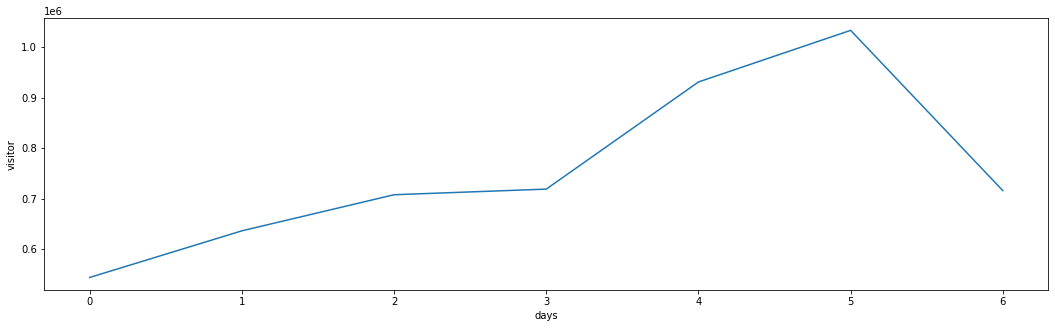

In [ ]:
# days = 0~6 까지 각각 월~일이다.
# 금~토에서의 방문자수가 가장 많음을 알 수 있다.
# 일별 데이터에서 그래프가 위아래로 요동치는 이유를 알 수 있다.

ax = air_visit_data_day['visitors'].plot(figsize=[18,5])
plt.xlabel('days')
plt.ylabel('visitor')

## 2.3 'sample_submission' 전처리

In [ ]:
# 원본
# sample_submission.csv 파일은 제출해야 할 파일의 예시본이기 때문에
# test data로 만들어 줄 것이다.
data['tes'].head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [ ]:
# 'visit_date' 열을 새로 만든 후 'id' 열을 '_' 기준으로 split 한 후 날짜만 따로 저장한다.
# 'air_store_id' 열을 새로 만든 후 'id' 열을 '_' 기준으로 split 한 후 날짜를 제외한 id 부분만 따로 저장한다.
# 이후 2.2 'air_visit_data' 전처리와 같이 전처리를 진행해준다.
# 즉, test, train의 dataframe을 맞춰주는 과정이다.

data['tes']['visit_date'] = data['tes']['id'].map(
    lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(
    lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [ ]:
data['tes'].head()

,id,visitors,visit_date,air_store_id,dow,year,month
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4


## 2.4 'stores' 생성 및 전처리



In [ ]:
# unique_stores 라는 변수에 'air_store_id'의 종류를 unique() 함수를 통해 지정해준다.
# 그 후 stores 라는 변수에 concat() 함수를 통해 'air_store_id' 열에 unique_stores를 지정하고 , 'dow' 열에 0~6까지 unique_stores의 수에 맞게끔 지정해준다. 

unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat(
    [pd.DataFrame({
            'air_store_id': unique_stores,
            'dow': [i] * len(unique_stores)
        }) for i in range(7)],axis=0,
    ignore_index=True).reset_index(drop=True)

In [ ]:
data['tra'].head()

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1


In [ ]:
# 'air_store_id', 'dow'로 groupby 해준 뒤 visitors의 min, mean, median, max, count_observations 값들을 각각의 이름으로 하여 새롭게 열을 생성한다.
# 그리고 위에서 생성한 stores 데이터프레임을 병합해준다.

# min : 기간 동안의 요일 당 방문한 방문객의 최소값
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow']) # 왼쪽에 입력한 데이터프레임 기준(how='left')으로, 각각의 key값에 해당하는 열을 지정해준다.

# mean : 기간 동안의 요일 당 방문한 방문객의 평균값
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

# median : 기간 동안의 요일 당 방문한 방문객의 중간값
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

# max : 기간 동안의 요일 당 방문한 방문객의 최대값
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

# count_observations : 기간 동안의 요일 당 방문한 팀수
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [ ]:
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0


In [ ]:
# 원본
data['air_store_info'].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [ ]:
# air_store_info.csv 에는 각 store의 위도, 경도 등등 store의 전반적인 정보를 담고있다.
# 따라서 위에서 처리한 stores 데이터프레임에 air_store_id를 기준으로 병합해준다.
# 이후 LabelEncoder()함수를 통해 air_genre_name	, air_area_name	열들을 정수로 라벨링 해준다.

stores = pd.merge(stores, data['air_store_info'], how='left', on=['air_store_id'])
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [ ]:
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,6,62,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,7,82,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,4,98,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,2,102,34.692337,135.472229


In [ ]:
# 각 요일의 가게의 최소, 평균, 중간, 최대 방문자들의 평균값을 구한다.
# 요일을 기준으로 정렬한다.

stores_v = stores.groupby('dow').sum()
stores_v = stores_v / len(unique_stores)
stores_v = stores_v.astype(int)

Text(0, 0.5, 'visitor')

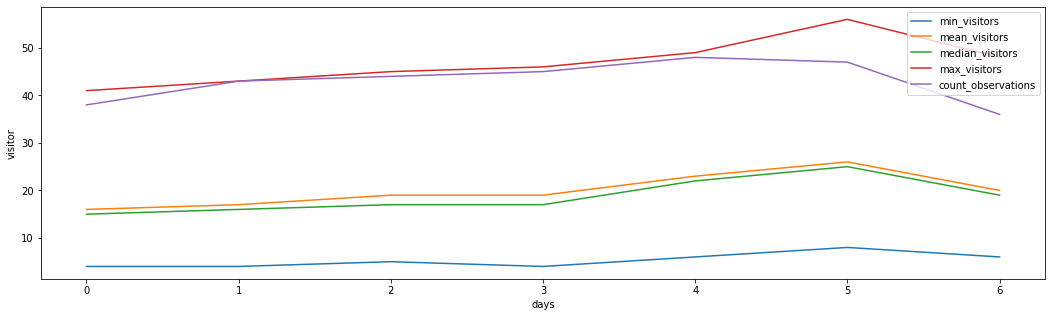

In [ ]:
# 전반적인 데이터 흐름은 비슷한 양상을 보여준다.
# 확실히 금요일~토요일 사이의 수치가 높음을 알 수 있다.

ax = stores_v['min_visitors'].plot(figsize=[18,5])
ax = stores_v['mean_visitors'].plot(figsize=[18,5])
ax = stores_v['median_visitors'].plot(figsize=[18,5])
ax = stores_v['max_visitors'].plot(figsize=[18,5])
ax = stores_v['count_observations'].plot(figsize=[18,5])
plt.legend(loc='upper right')
plt.xlabel('days')
plt.ylabel('visitor')

## 2.5 'date_info' 전처리

- 초기에 date_info.csv 파일을 불러올때 편의성을 위해 'calendar_date'를 'visit_date'로 rename하고 불러들였다.

In [ ]:
# 원본
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [ ]:
data['hol'].dtypes

visit_date     object
day_of_week    object
holiday_flg     int64
dtype: object

In [ ]:
# visit_date 열을 to_datetime 함수로 처리해준다.
# day_of_week 열의 요일을 정수로 라벨링해준다.

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [ ]:
data['hol'].head(12)

,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1
2,2016-01-03,3,1
3,2016-01-04,1,0
4,2016-01-05,5,0
5,2016-01-06,6,0
6,2016-01-07,4,0
7,2016-01-08,0,0
8,2016-01-09,2,0
9,2016-01-10,3,0


In [ ]:
# day_of_week 열이 정수가 됬음을 확인할 수 있다.
data['hol'].dtypes

visit_date     object
day_of_week     int64
holiday_flg     int64
dtype: object

## 2.6 train, test 데이터 프레임 생성 및 전처리(1)

In [ ]:
data['tra'].head()

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1


In [ ]:
data['tes'].head()

,id,visitors,visit_date,air_store_id,dow,year,month
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4


In [ ]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1
2,2016-01-03,3,1
3,2016-01-04,1,0
4,2016-01-05,5,0


In [ ]:
# air_visit_data.csv 와 date_info.csv를 visit_date 기준으로 병합하여 train 데이터프레임을 생성한다.
# store_id_relation.csv 와 data_info.csv를 visit_date 기준으로 병합하여 test 데이터프레임을 생성한다.

train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])

In [ ]:
train.head()

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0


In [ ]:
train.shape

(252108, 8)

In [ ]:
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,day_of_week,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,6,0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,4,0


In [ ]:
test.shape

(32019, 9)

In [ ]:
# 공휴일 여부에 따른 평균 방문자 수를 확인
# visitors_by_holiday: holiday_flg를 기준으로 그룹을 만들고, 그룹 내의 방문자 총합을 할당한 변수
# holiday_count: holiday_flg를 이용하여, train set 내 공휴일 수를 카운트하여 할당한 변수
visitors_by_holiday = train.groupby('holiday_flg')['visitors'].sum()
holiday_count = train['holiday_flg'].value_counts()
# value_count(): 각 데이터 별 count를 계산

# 각각의 변수에 할당된 값과 타입을 확인
print(holiday_count)
print(visitors_by_holiday)

0    239333
1     12775
Name: holiday_flg, dtype: int64
holiday_flg
0    4984843
1     302810
Name: visitors, dtype: int64


Text(0, 0.5, 'visitor')

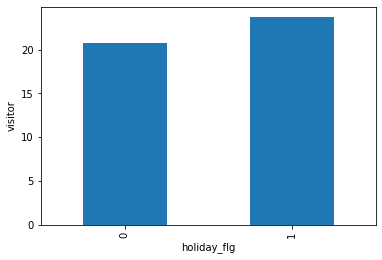

In [ ]:
# 앞서 할당한 변수, visitors_by_holiday와 holiday_count를 이용하여, 공휴일 여부에 따른 평균 방문자 수를 확인
visitors_by_holiday_per_count = visitors_by_holiday / holiday_count

ax = visitors_by_holiday_per_count.plot.bar()
plt.ylabel('visitor')

## 2.7 train, test 데이터 프레임 생성 및 전처리(2)

In [ ]:
# 위에서 처리중인 train 데이터프레임과 stores 데이터프레임을 air_store_id 기준으로 병합하여 최종적인 train 데이터프레임을 생성한다.
# store_id_relation.csv 와 data_info.csv를 visit_date 기준으로 병합하여 test 데이터프레임을 생성한다.

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id', 'dow'])
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id', 'dow'])

In [ ]:
train.head()

,air_store_id,visit_date,visitors,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599


In [ ]:
train.shape

(252108, 15)

In [ ]:
# air_reserve 와 hpg_reserve 데이터프레임을 train, test 데이터프레임에 병합시켜준다.

for df in ['air_reserve', 'hpg_reserve']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

col = [
    c for c in train
    if c not in ['id', 'air_store_id', 'visit_date', 'visitors']
]
train = train.fillna(-1)
test = test.fillna(-1)

In [ ]:
train.head()

,air_store_id,visit_date,visitors,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0


In [ ]:
train.shape

(252108, 19)

In [ ]:
test.shape

(32019, 20)

In [ ]:
train_x = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1)
train_y = np.log1p(train['visitors'].values)
print(train_x.shape, train_y.shape)
test_x = test.drop(['id', 'air_store_id', 'visit_date', 'visitors'], axis=1)

(252108, 16) (252108,)


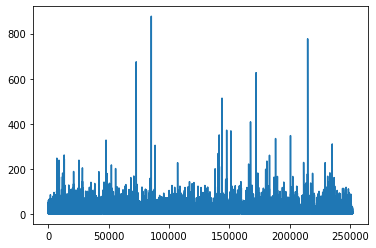

In [ ]:
plt.plot(np.expm1(train_y)) # 로그변환을 시켜주면 왜 결과값이 더 잘나오는지에 대한 이유?
plt.show()

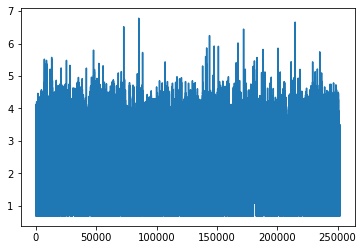

In [ ]:
plt.plot(train_y)
plt.show()

In [ ]:
train_x.head()

,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,2,2016,1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
1,3,2016,1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
2,4,2016,1,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
3,5,2016,1,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
4,0,2016,1,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0


In [ ]:
train_y

array([3.25809654, 3.49650756, 3.40119738, ..., 2.07944154, 2.19722458,
       1.79175947])

### 2.7.1 데이터셋이 결과값에 미치는 영향 확인

- 1차
  - 빠지는 열 없는 데이터

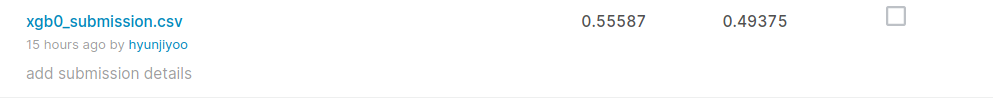

- 2차
  - Heatmap을 통해 Target data 인 visitors 와 min, meadian, mean, max visitors 들과의 상관관계도가 높은것을 기반으로 나머지 열들을 전부 제거한 뒤 모델을 돌려보았다.

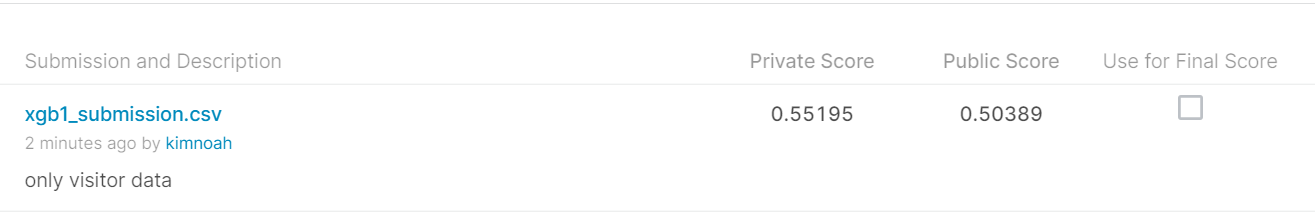

- 3차
  - Heatmap을 통해 min, meadian, mean, max visitors 과 target data 인 visitors 과의 상관관계를 확인했다.
  - 상대적으로 상관관계도가 높은 mean_visitors의 열을 제외한 'min_visitors', 'median_visitors', 'max_visitors','count_observations' 4가지 열을 삭제한 후 모델을 돌려 보았다.

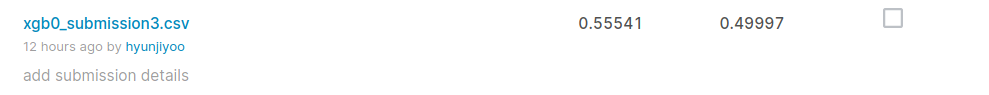

- 4차
  - 'air_genre_name', 'latitude', 'longitude'의 열이 어느정도의 영향력을 끼치는지 확인하기 위해 세 개의 열을 삭제한 후 모델을 돌려 보았다.

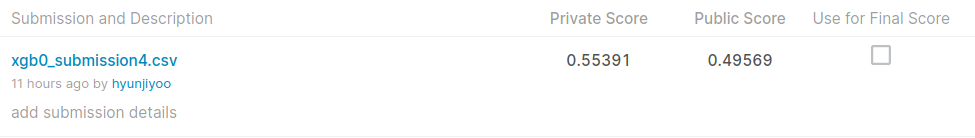

#### 2.7.1.1 Result visualization

In [ ]:
# 원본
result_df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/kaggle/first/data/result/result.csv')
result_df.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.962
1,air_00a91d42b08b08d9_2017-04-24,22.543
2,air_00a91d42b08b08d9_2017-04-25,24.968
3,air_00a91d42b08b08d9_2017-04-26,28.266
4,air_00a91d42b08b08d9_2017-04-27,31.240


In [ ]:
result_df['visit_date'] = result_df['id'].map(
    lambda x: str(x).split('_')[2])
result_df['air_store_id'] = result_df['id'].map(
    lambda x: '_'.join(x.split('_')[:2]))
result_df['visit_date'] = pd.to_datetime(result_df['visit_date'])
result_df['dow'] = result_df['visit_date'].dt.dayofweek
result_df['year'] = result_df['visit_date'].dt.year
result_df['month'] = result_df['visit_date'].dt.month
result_df['visit_date'] = result_df['visit_date'].dt.date
result_df.set_index('visit_date', inplace=True)
result_df.drop(['id'], axis=1)

,visitors,air_store_id,dow,year,month
visit_date,,,,,
2017-04-23,1.962,air_00a91d42b08b08d9,6,2017,4
2017-04-24,22.543,air_00a91d42b08b08d9,0,2017,4
2017-04-25,24.968,air_00a91d42b08b08d9,1,2017,4
2017-04-26,28.266,air_00a91d42b08b08d9,2,2017,4
2017-04-27,31.240,air_00a91d42b08b08d9,3,2017,4
...,...,...,...,...,...
2017-05-27,6.615,air_fff68b929994bfbd,5,2017,5
2017-05-28,3.115,air_fff68b929994bfbd,6,2017,5
2017-05-29,3.459,air_fff68b929994bfbd,0,2017,5


In [ ]:
result_df.head()

,id,visitors,air_store_id,dow,year,month
visit_date,,,,,,
2017-04-23,air_00a91d42b08b08d9_2017-04-23,1.962,air_00a91d42b08b08d9,6,2017,4
2017-04-24,air_00a91d42b08b08d9_2017-04-24,22.543,air_00a91d42b08b08d9,0,2017,4
2017-04-25,air_00a91d42b08b08d9_2017-04-25,24.968,air_00a91d42b08b08d9,1,2017,4
2017-04-26,air_00a91d42b08b08d9_2017-04-26,28.266,air_00a91d42b08b08d9,2,2017,4
2017-04-27,air_00a91d42b08b08d9_2017-04-27,31.240,air_00a91d42b08b08d9,3,2017,4


In [ ]:
air_visit_data = data['tra'].groupby('visit_date').sum()
air_visit_data.head()

,visitors,dow,year,month
visit_date,,,,
2016-01-01,1033,192,96768,48
2016-01-02,1764,315,127008,63
2016-01-03,2368,486,163296,81
2016-01-04,3326,0,316512,157
2016-01-05,3927,231,465696,231


In [ ]:
result_df_data = result_df.groupby('visit_date').sum()
result_df_data

,visitors,dow,year,month
visit_date,,,,
2017-04-23,15604.822,4926,1655957,3284
2017-04-24,11251.151,0,1655957,3284
2017-04-25,12236.510,821,1655957,3284
2017-04-26,13523.849,1642,1655957,3284
2017-04-27,13464.913,2463,1655957,3284
2017-04-28,17503.355,3284,1655957,3284
2017-04-29,19401.830,4105,1655957,3284
2017-04-30,15302.833,4926,1655957,3284
2017-05-01,11237.262,0,1655957,4105


Text(0, 0.5, 'visitor')

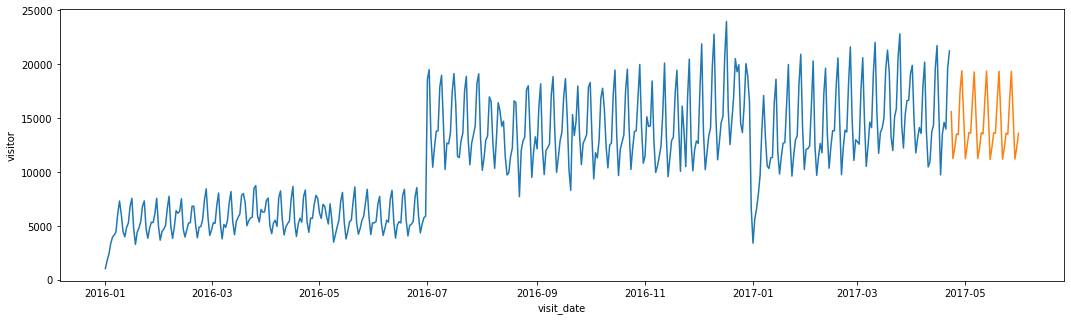

In [ ]:
# 일별 예측
ax1 = air_visit_data['visitors'].plot(figsize=[18,5])
ax2 = result_df_data['visitors'].plot(figsize=[18,5])
plt.ylabel('visitor')

# 3. Heatmap

In [ ]:
!pip install --upgrade mlxtend

     |████████████████████████████████| 1.3 MB 7.4 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

In [ ]:
cols = ['visitors', 'min_visitors', 'median_visitors', 'max_visitors', 'mean_visitors', 'count_observations',]

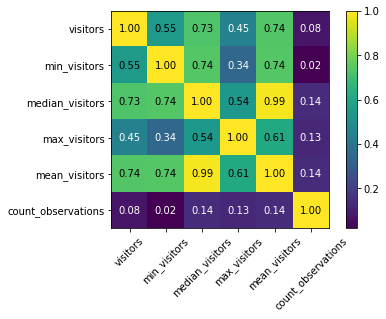

In [ ]:
cm = np.corrcoef(train[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)
plt.show()

['visitors' 'mean_visitors' 'median_visitors' 'max_visitors'
 'min_visitors' 'dow' 'count_observations' 'reserve_visitors_x'
 'reserve_datetime_diff_x' 'reserve_visitors_y' 'reserve_datetime_diff_y'
 'air_genre_name' 'air_area_name' 'longitude' 'year' 'latitude' 'month']


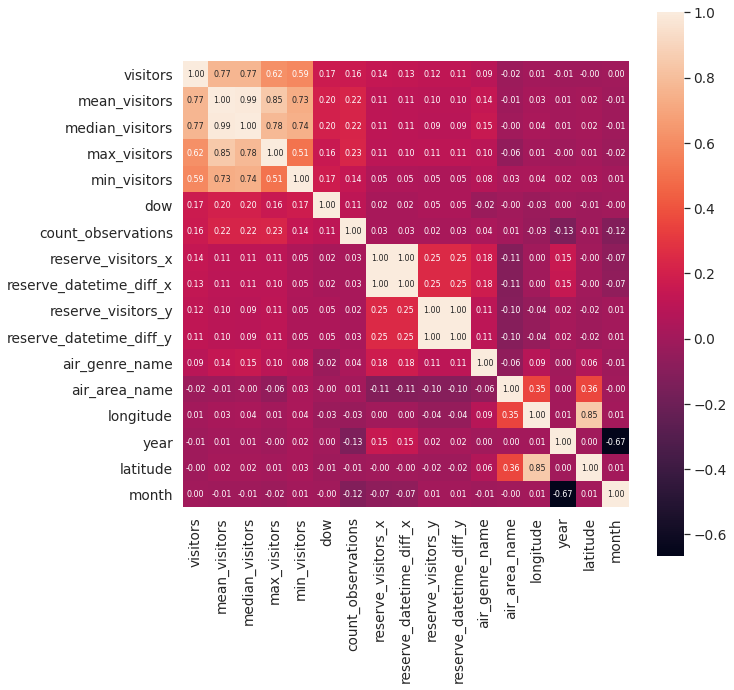

In [ ]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=19, columns='visitors').index
# price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

# 4. Model

## 4.1 RMSE 계산

In [ ]:
plt.su

In [ ]:
# 필요한 모듈 불러오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
# RMSE를 로그변환에서 다시 역변환 시켜주는 함수를 구현한다.
def rmse(y_test, predict_y):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(predict_y)))

In [ ]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        predict_y = model.predict(X_test)
        
        df[model_name] = rmse(y_test, predict_y)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [ ]:
get_scores(models, train_x, train_y)

**get_scores 결과(4가지 모델)**
- 좋은 결과를 도출한 XGBRegressor와 GradientBoostingRegressor 사용

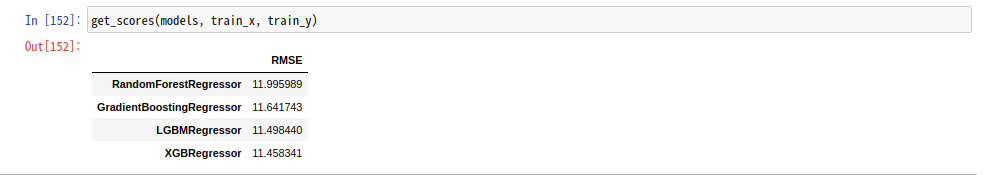

## 4.2 Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# 위의 과정을 하나의 함수로 표현한다.
def my_GridSearch(model, train_x, train_y, param_gird, verbose=2, n_jobs=-1):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(train_x, train_y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

**그리드 서치 결과(LGMRegressor)**

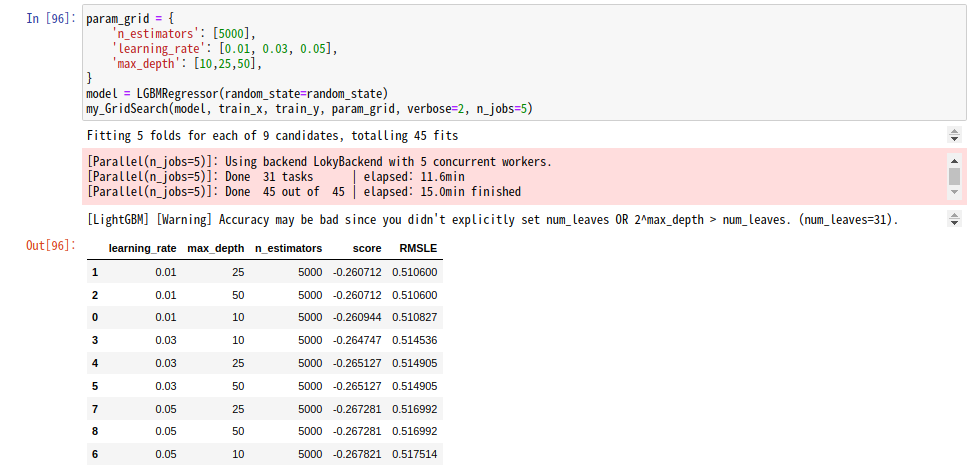

## 4.3 Parameter tuning

- XGBRegressor parameters
  - 

### 4.3.1 XGBRegressor

In [ ]:
boost_params = {'eval_metric': 'rmse'}
xgb0 = xgb.XGBRegressor(
    max_depth=8,
    learning_rate=0.01,
    n_estimators=10000,
    objective='reg:squarederror',
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    scale_pos_weight=1,
    seed=27,
    **boost_params)

xgb0.fit(train_x, train_y)
predict_y = xgb0.predict(test_x)
test['visitors'] = np.expm1(predict_y)
test[['id', 'visitors']].to_csv(
    'xgb0_submission.csv', index=False, float_format='%.3f')

XGBRegressor [변수 설명](https://statkclee.github.io/model/model-python-xgboost-hyper.html) 참고자료입니다.


### 4.3.2 LGBM

In [ ]:
param_grid = {
    'n_estimators': [450, 500, 550, 600, 650, 700],
    'max_depth': [11, 13, 15, 17, 19],
    'num_leaves': [15, 30],
    'learning_rate': [0.01, 0.05, 0,1]
}
model_lgbm = LGBMRegressor(random_state=random_state)
my_GridSearch(model_lgbm, train_x, train_y, param_grid, verbose=2, n_jobs=5)

In [ ]:
model_lgbm = LGBMRegressor(learning_rate=0.05, max_depth=13, n_estimators=700, num_leaves=30, random_state=random_state)
model_lgbm.fit(train_x, train_y)
prediction_lgbm = model_lgbm.predict(test_x)
prediction_lgbm

In [ ]:
prediction_lgbm = np.expm1(prediction_lgbm)
prediction_lgbm

In [ ]:
test['visitors'] = prediction_lgbm
test[['id', 'visitors']].to_csv(
    'lgbm_submission.csv', index=False, float_format='%.3f')

---

In [ ]:
prediction_xgb = np.expm1(predict_y)

prediction_ensemble = np.vstack([prediction_lgbm, prediction_xgb]).mean(0)

test['visitors'] = prediction_ensemble
test[['id', 'visitors']].to_csv(
    'xgb_lgbm_ensemble_submission.csv', index=False, float_format='%.3f')

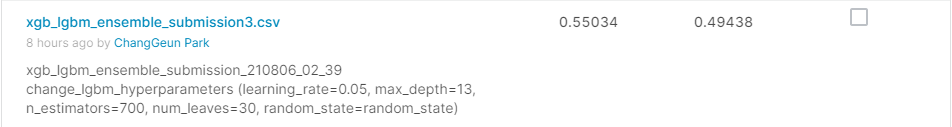

In [ ]:
!pip install catboost

from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=16, l2_leaf_reg=20, bootstrap_type='Bernoulli', subsample=0.6, eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
model_cat.fit(train_x, train_y)
prediction_cat = model_cat.predict(test_x)
prediction_cat

In [ ]:
prediction_cat = np.expm1(prediction_cat)
prediction_cat

test['visitors'] = prediction_cat
test[['id', 'visitors']].to_csv(
    'cat_submission.csv', index=False, float_format='%.3f')

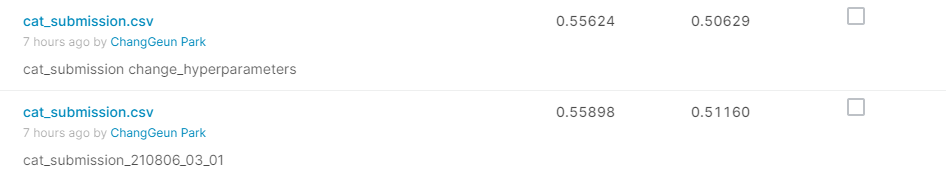

In [ ]:
prediction_ensemble2 = np.vstack([prediction_lgbm, prediction_xgb, prediction_cat]).mean(0)

test['visitors'] = prediction_ensemble2
test[['id', 'visitors']].to_csv(
    'xgb_lgbm_cat_ensemble_submission.csv', index=False, float_format='%.3f')

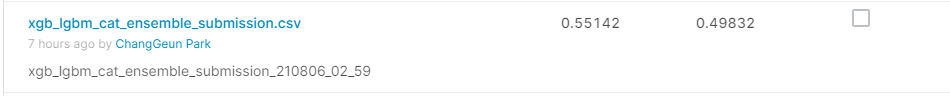

---

최종 하이스코어: Public Score 0.49333

In [ ]:
# 최종 하이스코어 하이퍼 파라미터
model_lgbm = LGBMRegressor(learning_rate=0.05, max_depth=13, n_estimators=700, num_leaves=30, random_state=random_state)

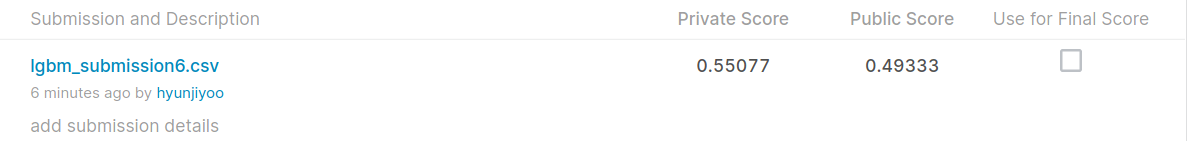

# 스코어 도출 과정:   
1. 레퍼런스 기반 스코어 점수 탐색
2. 하이퍼파라미터 고정 후 train_x 데이터셋 변경   
    -> 효과가 없어 데이터셋은 처음대로 유지
3. 모델 성능 검증 및 그리드 서치로 하이퍼파라미터 탐색  
    -> EXPLORATION에 있는 코드 활용  
    -> 그리드서치 시간 소요 등 다른 방안을 강구하기 함
4. 앙상블  
    -> 스코어 적인 측면에서 효과를 갖는 하이퍼파라미터 및 모델 설정 실패  
5. 다시 하이퍼파라미터 재탐색  
    -> 분담하여 훈련시켜 가장 좋은 스코어를 내는 값을 찾음

# 5. 회고

## 유현지

**배운 점**
- 세상 제일은 화목이란걸 배웠다. 화목하니 행복했다.
- 협업하는 과정에 대해 생각하게 되었다. 
- 함께 해결하는 것이 거의 처음이인데 팀원들을 통해 혼자 했을 때 해결하지 못한 부분에 대해 재검토가 가능했다.
- 추가적으로 첫날에는 사실 아무것도 못한 것 같아 너무 분하고 미안했다.
- 질투는 나의 힘이기 때문에 그 덕에 더 열중하지 않았나 생각한다.
- 스스로의 장단점에 대해 생각하고 이를 보완하고 갈고 닦아야 한다고 다짐했다.
  (장- 발표력과 추진력?ㅎㅎ, 단- 코드작성실력)


**아쉬운 점**  
- 시간적인 여유가 있었다면 좀 더 좋은 스코어와 직접 새로운 데이터 창출을 해내지 않았을까 싶다.
- 이 팀이라면 가능할 텐데 그 점이 제일 아쉽다.
- 스코어에 치중되어서 모델을 튜닝했지만 논리적으로 뒷받침할 만한 자료나 코드들이 더 보충되었으면 한다.

**소감**  
- 저희 조의 목표는 화목이였는데 목표달성하고 해커톤을 종료해서 기쁩니다.  
- 좋은 레퍼런스를 찾고 코드 정리에 힘써주신 지윤님,  
- 모델과 시각화의 기초를 잡고 이끌어주신 창근님 모두 감사합니다.  
- 발표는 저에게 맡기시고 해커톤 축제를 즐기세요!

## 김지윤

**전처리**
- 처음 데이터를 받았을 때 전처리해야할 데이터들도 많고 어떻게 해야할지 감이 잡히지 않았습니다.
- 팀원들과 회의를 통해 처음부터 건드리기에는 시간이 부족하다 판단이 되어 참고할 만한 템플릿을 하나 지정하여 진행해 나가기로 방향을 정했습니다.
- 전처리 과정 중 모르는 부분을 agit 그룹과 회의를 통해 지속적으로 보충해나가 전반적인 그림을 그릴 수 있었습니다.

**시각화**
- 전처리를 하는 과정 중 시각화를 할 수 있다고 판단되는 데이터를 모두 시각화를 해 나갔습니다.
- 후에 다시 한번 훑어보면서 상대적으로 필요하다 생각되는 시각화 데이터를 남기고 나머지를 지워나가는 방식으로 진행했습니다.
- 추가적으로 Heatmap을 통해 Target data인 visitor과 나머지 열에 대한 상관관계 점수를 통해 각 열들의 가중치를 확인할 수 있었습니다.

**모델**
- Exploration 6 캐글 연습에서 사용했던 RMSE 계산을 통해 여러개의 모델들의 점수를 확인할 수 있었으며, 모델 선정에 좋은 영향을 끼쳤습니다.
- 선정된 모델의 하이퍼파라미터를 다양하게 조절해봄으로써 모델의 성능을 확인해 볼 수 있었습니다.
- 선정된 모델 이외에도 다른 모델들과의 앙상블을 통해 모델의 성능 개선에 많은 시도를 해보았습니다.

**소감**
- 전반적으로 개별적으로 파트를 맡지 않고 전처리부터 모델링까지 같이 진행하였기 때문에 더 좋은 성과를 얻을 수 있었던것 같습니다.
- 현지님께서는 꼼꼼하게 여러번 데이터를 확인해주셔서 전처리를 함에 있어 각각의 csv 파일의 구체적인 이해와 제가 궁금했던 또는 모르는 부분에 대해
확실하게 집고 넘어갈 수 있었습니다. 또한, 모델링을 함에 있어 다양한 파라미터를 실험해보고 데이터를 다르게 전처리하여 각 열이 타깃값을 출력함에
있어 어떠한 영향을 끼치는지 명확하게 알 수 있었습니다.
- 창근님께서는 전반적인 시각화에 대하여 틀을 잡아주시고, 다양한 아이디어를 공유함으로써 막막했던 시각화 부분을 효율적으로 해나갈 수 있었습니다.
또한, XGBoost 뿐만 아니라 LGBM 등 다양한 모델들을 보다 깊게 파고들어 앙상블하는 실험도 해보는 등의 방법을 통해 다양하게 모델을 비교해볼 수 있
어 마음이 한결 놓였습니다.
- 이외에도 팀원들 모두가 모든 부분에서 좋은 영향을 끼치고, 많은 것을 배웠으며, 다른 시각으로 문제를 바라볼 수 있었습니다. 그리고 프로젝트를 진행함
에 있어 의견충돌 없이 서로 배려함으로써 끝까지 화목하게 끝낼 수 있었기에 편한 마음으로 진행할 수 있어 좋았습니다.

## 박창근

캐글을 개인적으로 진행했다면, 좋은 스코어는 커녕, 제출도 못했을 거라고 생각합니다. 지윤님과 현지님, 두 분께서 너무 열심히 해주시고, 잘 해주셔서 좋은 스코어를 받았다고 생각하고, 두 분 덕분에 해커톤을 잘 마무리했다고 생각합니다. 해커톤 진행하면서 팀원들과 어떻게 커뮤니케이션을 진행해야 하는지 많이 배웠고,
앞으로 종종 팀으로 프로젝트를 진행할 기회가 더 많았으면 좋겠습니다.